In [1]:
%env CUDA_VISIBLE_DEVICES=3
import sys
sys.path.append('/home/a_razumov/projects/k-space-mri')
import numpy as np
import pylab as plt
import pickle
from tqdm import tqdm

import torch
torch.set_num_threads(38)
import torch.nn.functional as F

from k_space_reconstruction.utils.metrics import pt_msssim, pt_ssim
from k_space_reconstruction.datasets.acdc import ACDCSet, ACDCTransform, RandomMaskFunc
from k_space_reconstruction.datasets.fastmri import FastMRIh5Dataset, FastMRITransform, LegacyFastMRIh5Dataset
from k_space_reconstruction.utils.kspace import EquispacedMaskFunc, RandomMaskFunc
from k_space_reconstruction.utils.kspace import pt_spatial2kspace as Ft
from k_space_reconstruction.utils.kspace import pt_kspace2spatial as IFt

import os
import sys
from k_space_reconstruction.nets.unet import Unet
from k_space_reconstruction.nets.enet import ENet
from k_space_reconstruction.nets.mwcnn import MWCNN
import datetime
import torch
import torchvision
import numpy as np
import pylab as plt
plt.style.use('dark_background')
import numpy as np
import h5py
import pylab as plt
import torch
import torch.nn.functional as F

import os
import re
import numpy as np
import pandas as pd

import torch
import torch.utils.data
import torchvision.transforms as transforms

from torch.fft import ifftn, fftn, fftshift, ifftshift

from os.path import isdir, join
from typing import Callable, Dict, List, Any

env: CUDA_VISIBLE_DEVICES=3


In [2]:
fig_bezzeless = lambda nc, nr : plt.subplots(ncols=nc, nrows=nr, figsize=(4 * nc, 4), dpi=120, 
                                             subplot_kw=dict(frameon=False, xticks=[], yticks=[]), 
                                             gridspec_kw=dict(wspace=0.0, hspace=0.0))


def ce_loss(true, logits, weights, ignore=255):
    torch.nn.CrossEntropyLoss
    ce_loss = torch.nn.functional.cross_entropy(
        logits.float(),
        true.long(),
        ignore_index=ignore,
        weight=weights,
    )
    return ce_loss

def pt_psnr(img1, img2, maxval):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(maxval / torch.sqrt(mse))

def dice_loss(true, logits, eps=1e-7):
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = torch.nn.functional.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

def dice_coeffs(true, logits):
    num_classes = logits.shape[1]
    probas = F.softmax(logits, dim=1)
    probas[probas > 0.5] = 1; probas[probas <= 0.5] = 0
    pmask = torch.zeros_like(true).float()
    for i in range(1, num_classes):
        pmask[:,0] += i * probas[:,i]
    dice_ls = []
    for i in range(1, num_classes):
        yt = (true==i).float().flatten()
        yp = (pmask==i).float().flatten()
        intersection = torch.sum(yt * yp)
        cardinality = torch.sum(yt + yp)
        dice_ls.append((2. * intersection / (cardinality + 1e-7)).item())
    return dice_ls        

@torch.no_grad()
def test_sampling_pattern(sampling, model, val_generator):
    dice_scores = []
    for data in val_generator:
        simg = IFt(Ft(data['img'] * data['std'] + data['mean']) * sampling).abs()
        pm = model(simg)
        gt = data['mask'].long()
        for i in range(simg.shape[0]):
            dice_scores.append(1 - dice_loss(gt[i][None], pm[i][None]).item())
    return dice_scores

@torch.no_grad()
def test_on_classes_sampling_pattern(sampling, model, val_generator):
    dice_scores = []
    for data in val_generator:
        simg = IFt(Ft(data['img'] * data['std'] + data['mean']) * sampling).abs()
        pm = model(simg)
        gt = data['mask'].long()
        for i in range(simg.shape[0]):
            dice_scores.append(dice_coeffs(gt[i][None], pm[i][None]))
    return dice_scores

class ACDCDataset(torch.utils.data.Dataset):
    CLASSES = {0: 'NOR', 1: 'MINF', 2: 'DCM', 3: 'HCM', 4: 'RV'}

    def __init__(self, hf_path, device):
        super().__init__()
        self.device = device
        self.hf = h5py.File(hf_path)

    def __len__(self) -> int:
        return len(self.hf)

    def __getitem__(self, item: int):
        img = self.hf[str(item)][:1]
        mask = self.hf[str(item)][1:]
        c = self.hf[str(item)].attrs['class']
        img = torch.tensor(img).float()
        mask = torch.tensor(mask)
        mean = img.mean()
        std = img.std()
        img = (img - mean) / (std + 1e-11)
        return dict(
            c=c, 
            mask=mask.to(self.device), 
            img=img.to(self.device), 
            mean=mean[None, None, None].to(self.device), 
            std=std[None, None, None].to(self.device)
        )

In [3]:
np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_dataset = ACDCDataset('/home/a_razumov/small_datasets/acdc_seg_h5/train.h5', device)
val_dataset = ACDCDataset('/home/a_razumov/small_datasets/acdc_seg_h5/val.h5', device)

# train_dataset = torch.utils.data.Subset(train_dataset, [0])

train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

In [4]:
model = Unet(1, 3+1).to(device).train(False).eval()
for p in model.parameters():
    p.requires_grad = False
model.load_state_dict(
    torch.load('/home/a_razumov/projects/k-space-mri/notebooks/TMI/acdc/unet-acdc-norot.pt', 
    map_location=device)
)

<All keys matched successfully>

In [5]:
fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [8])((256, 256))[0]).to(device).float()
zm = torch.zeros(256).to(device).float()
zm[256//2 - int(32)//2 : 256//2 + int(32)//2] = 1
fm = torch.ones(256).to(device).float()

  0%|          | 0/32 [00:00<?, ?it/s]

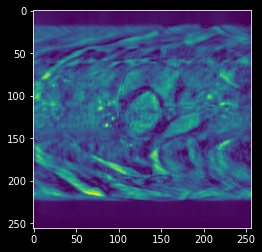

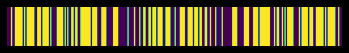

  3%|▎         | 1/32 [00:10<05:22, 10.41s/it]

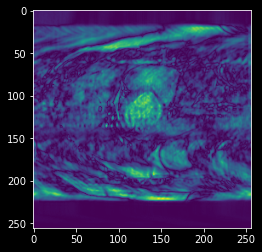

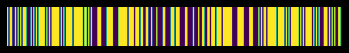

  6%|▋         | 2/32 [00:19<04:57,  9.91s/it]

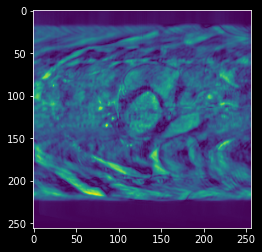

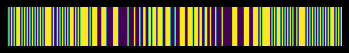

  9%|▉         | 3/32 [00:29<04:42,  9.75s/it]

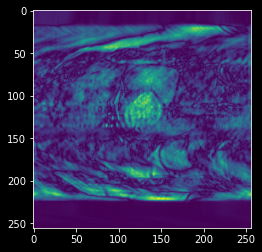

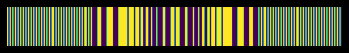

 12%|█▎        | 4/32 [00:41<04:52, 10.44s/it]


KeyboardInterrupt: 

In [5]:
w = torch.ones(256).float().to(device)
pbar = tqdm(range(32))
for _ in pbar:
    w.requires_grad = True
    for data in train_generator:
        simg = IFt(Ft(data['img'] * data['std'] + data['mean']) * w).abs()
        simg = (simg - data['mean']) / (data['std'] + 1e-11)
        dice_loss(data['mask'].long(), model(simg)).backward()
    g = w.grad.detach()
    w = w.detach()
    w[g >= 0] = 0
    w[g < 0] = 1
    # Verbose
    data = train_dataset[0]
    simg = IFt(Ft(data['img'] * data['std'] + data['mean']) * w).abs()
    plt.imshow(simg[0].cpu())
    plt.show()
    plt.imshow(w.repeat(30,1).cpu())
    plt.axis('off')
    plt.show()

tensor(32., device='cuda:0')


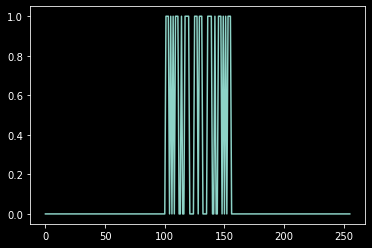

In [10]:
print(w.sum())
plt.plot(w.cpu())
plt.show()

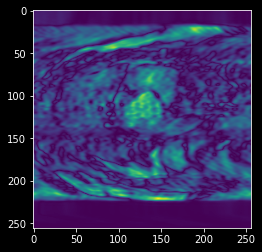

In [11]:
data = train_dataset[0]
simg = IFt(Ft(data['img'] * data['std'] + data['mean']) * w).abs()
plt.imshow(simg[0].cpu())

In [9]:
torch.save(w, 'igs.pt')

In [10]:
# torch.save(loupe_w, 'loupe.pt')
# our_w = torch.load('./acdc_igs_masks.pt')[-2]
our_w = torch.load('./igs.pt').to(device)
loupe_w = torch.load('./loupe.pt').to(device)

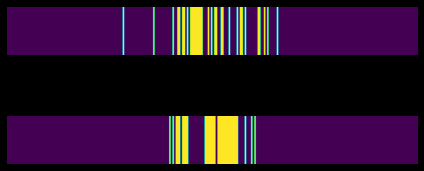

In [11]:
plt.subplot(211)
plt.imshow(our_w.repeat(30,1).cpu())
plt.axis('off')
plt.subplot(212)
plt.imshow(loupe_w.repeat(30,1).cpu())
plt.axis('off')
plt.tight_layout()
plt.show()

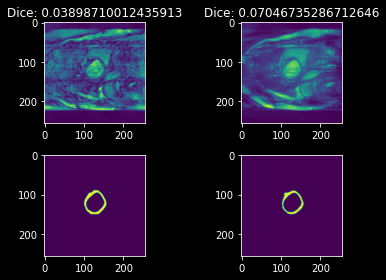

In [12]:
data = train_dataset[0]

plt.subplot(221)
simg = IFt(Ft(data['img'] * data['std'] + data['mean']) * our_w).abs()
plt.imshow(simg[0].cpu())
dv = dice_loss(data['mask'][None].long(), model(simg[None])).item()
plt.title(f'Dice: {dv}')
plt.subplot(223)
plt.imshow(model(simg[None]).softmax(1)[0,2].cpu())
plt.subplot(222)
simg = IFt(Ft(data['img'] * data['std'] + data['mean']) * loupe_w).abs()
plt.imshow(simg[0].cpu())
dv = dice_loss(data['mask'][None].long(), model(simg[None])).item()
plt.title(f'Dice: {dv}')
plt.subplot(224)
plt.imshow(model(simg[None]).softmax(1)[0,2].cpu())
plt.tight_layout()
plt.show()

In [13]:
dice_scores = dict(
    fastmri=test_sampling_pattern(fastmri_mask_x16, model, val_generator), 
    center=test_sampling_pattern(zm, model, val_generator),
    loupe=test_sampling_pattern(loupe_w, model, val_generator),
    ours=test_sampling_pattern(our_w, model, val_generator),
    full=test_sampling_pattern(fm, model, val_generator),
)

df_dice = pd.DataFrame.from_dict(dice_scores)
df_dice.describe()

,fastmri,center,loupe,ours,full
count,514.000000,514.000000,514.000000,514.000000,514.000000
mean,0.582251,0.756240,0.778428,0.517665,0.842170
std,0.201467,0.196244,0.189261,0.247281,0.177547
min,0.236445,0.247208,0.247186,0.241410,0.247338
25%,0.428309,0.642304,0.675209,0.249519,0.837920
50%,0.616289,0.855707,0.869964,0.501571,0.923483
75%,0.765419,0.896330,0.912876,0.777954,0.945267
max,0.883566,0.940497,0.954240,0.928178,0.970603
